In [1]:
from visualisation import visualise_features, visualise_dataset
from utilities import load_dataframe, performance, cross_validation_feature_params

In [2]:
# Restart the kernel if needed
# import os
# os._exit(00)

## Exploratory Data Analysis
### Visualise our data

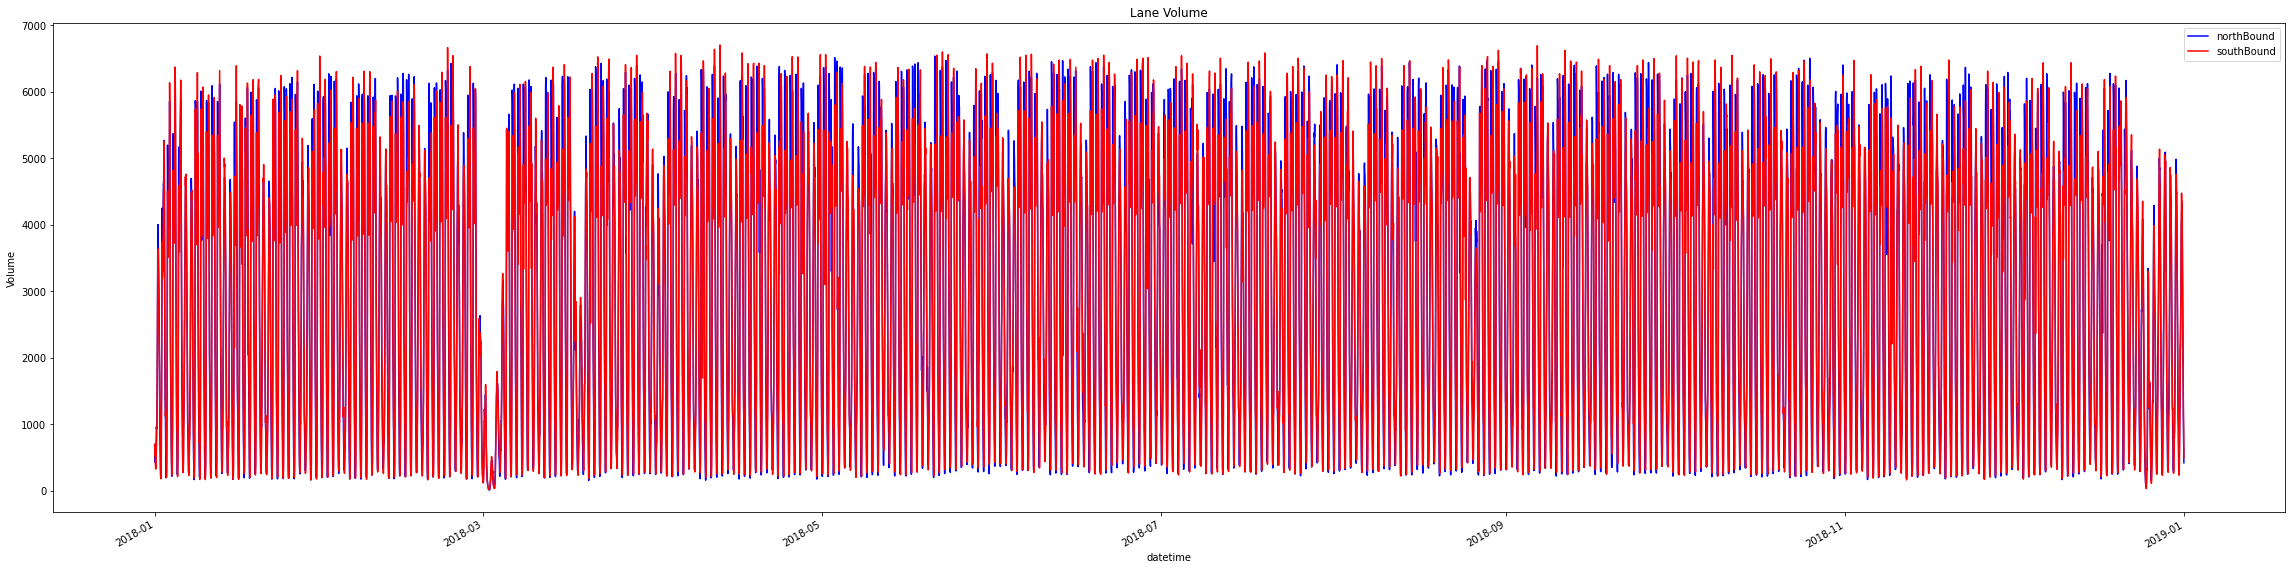

In [3]:
# Get our dataframe
df = load_dataframe()
visualise_dataset(df)

This doesn't tell us a huge amount. Let's split the volume directions up into separate dataframes and have a closer look.

In [31]:
# Create two separate data frames, one for each junction
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

For each dataframe, let's look at a seasonality and trend plot. This could illuminate some more details to us

Base MSE for northBound traffic is: 852.7132934666291
Base MSE for southBound traffic is: 828.866384429772


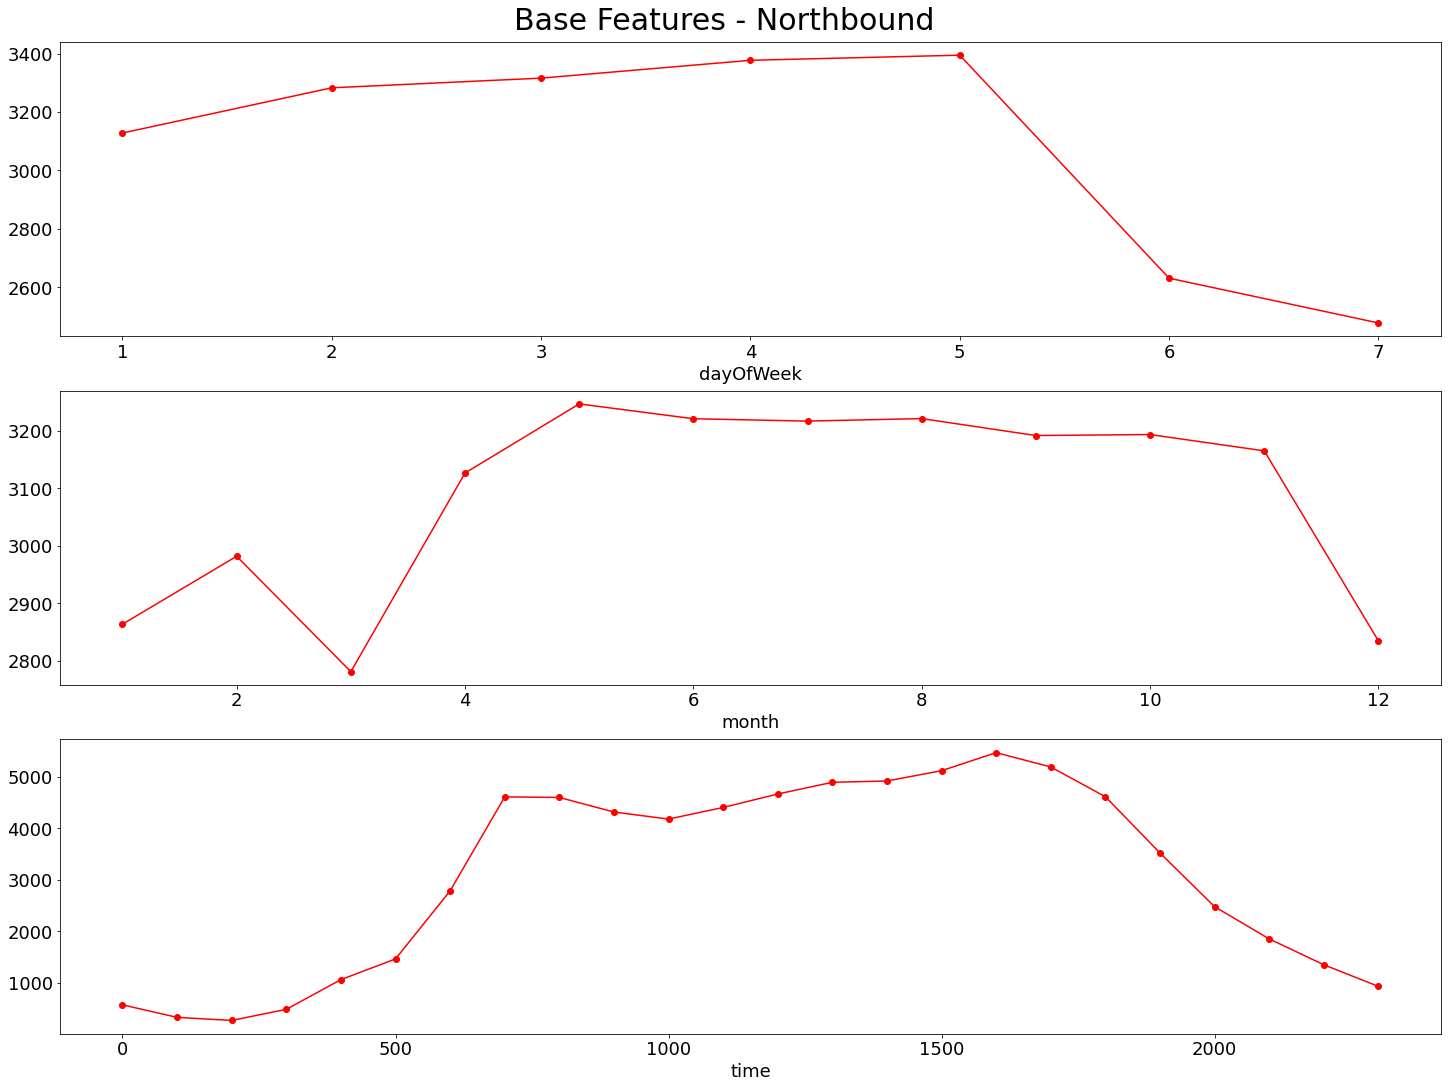

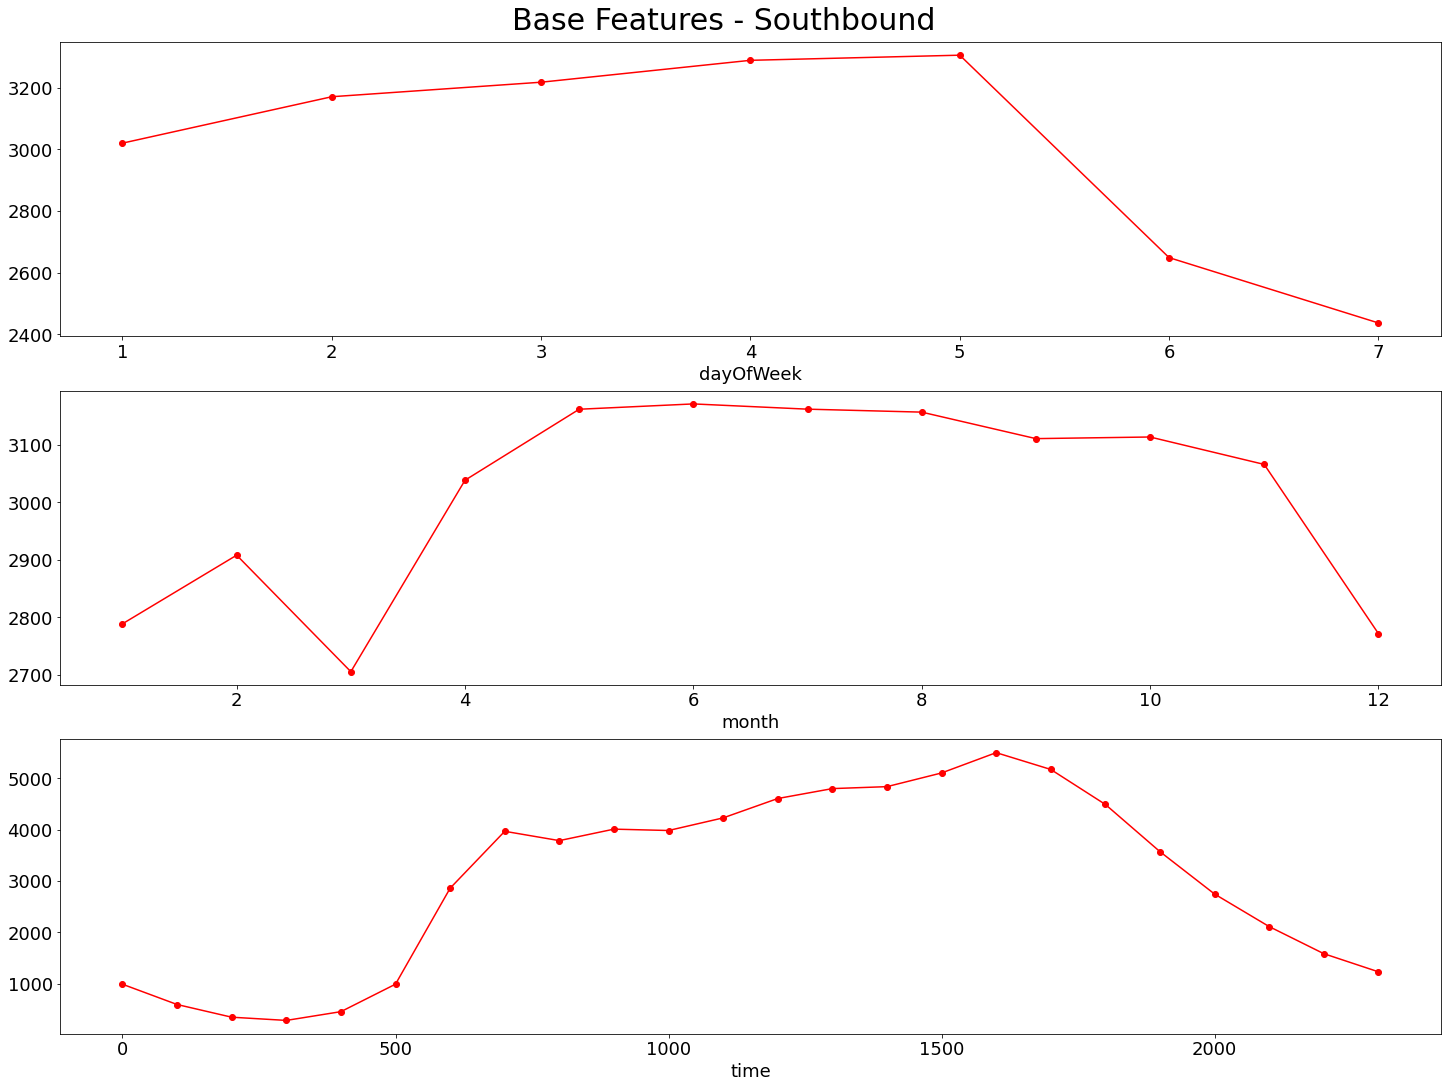

In [18]:
# Base features performance, where we use K Nearest Neighbors.
# Here is our baseline, now we add features.
performance(df_north, "northBound")
visualise_features(["dayOfWeek", "month", "time"], df_north, f"Base Features - Northbound", "northBound")

performance(df_south, "southBound")
visualise_features(["dayOfWeek", "month", "time"], df_south, f"Base Features - Southbound", "southBound")

### We see:
1. A weekly seasonality
2. A yearly seasonality
3. No overall trend throughout the year

### Extra Features

In [19]:
df_north["quarter"] = df.index.quarter
df_north["weekOfYear"] = df.index.weekofyear
df_north["dayOfYear"] = df.index.dayofyear

df_south["quarter"] = df.index.quarter
df_south["weekOfYear"] = df.index.weekofyear
df_south["dayOfYear"] = df.index.dayofyear

/tmp/ipykernel_14231/3101943268.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_north["weekOfYear"] = df.index.weekofyear
/tmp/ipykernel_14231/3101943268.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_south["weekOfYear"] = df.index.weekofyear


Base MSE for northBound traffic is: 1093.632445917954
Base MSE for southBound traffic is: 1038.3775002449338


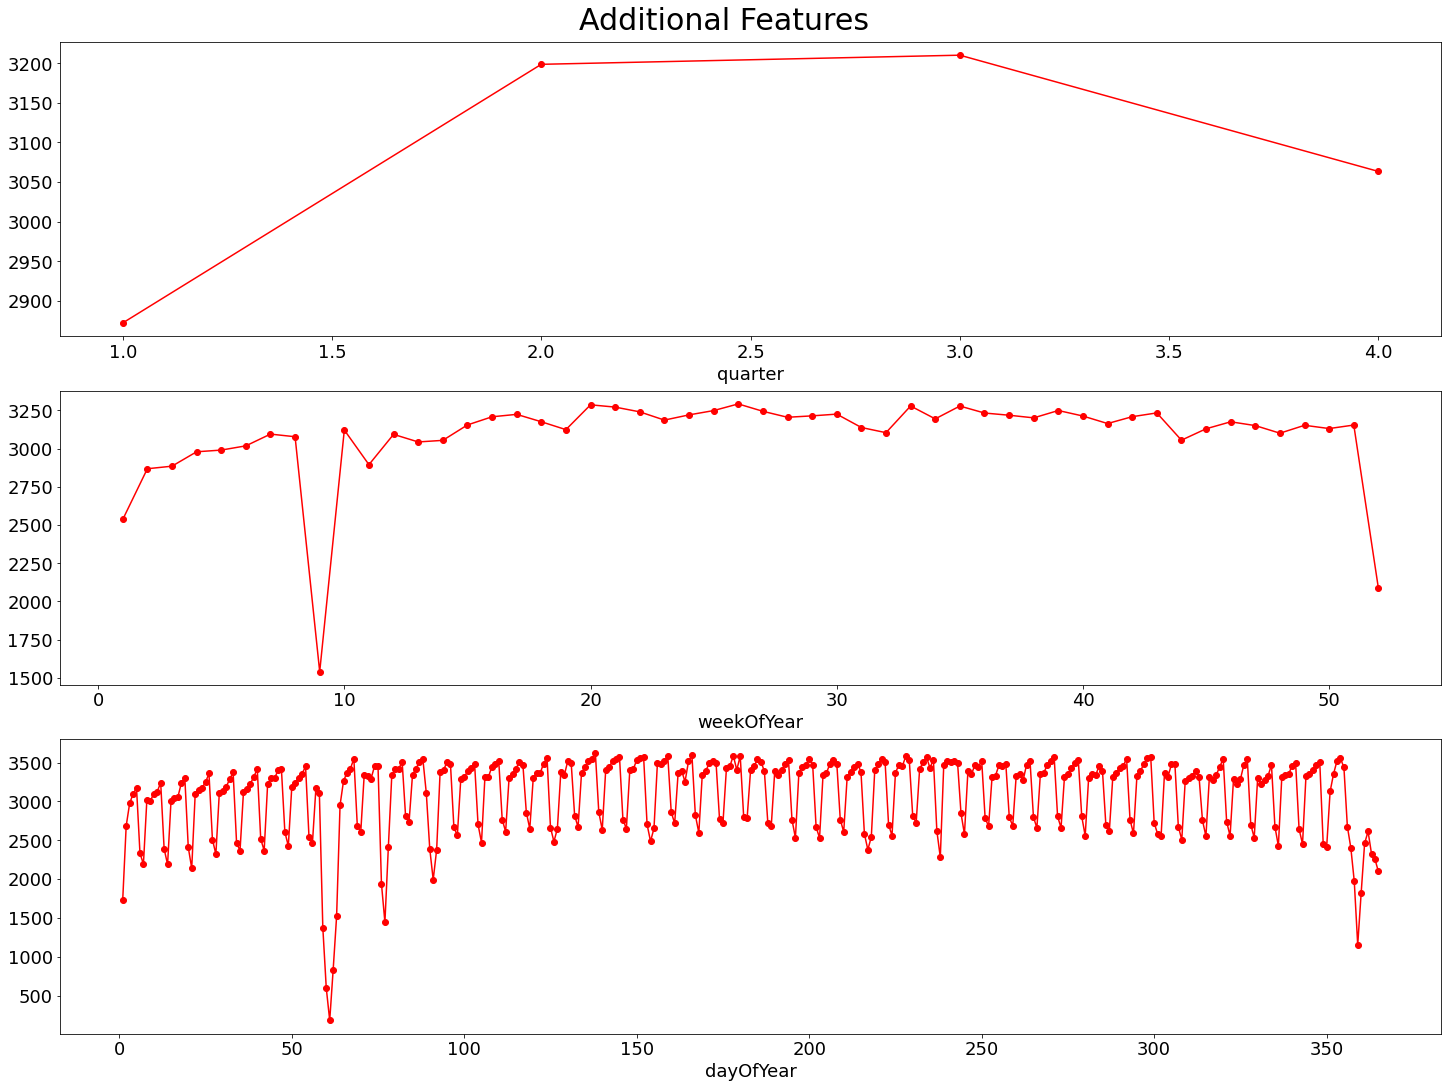

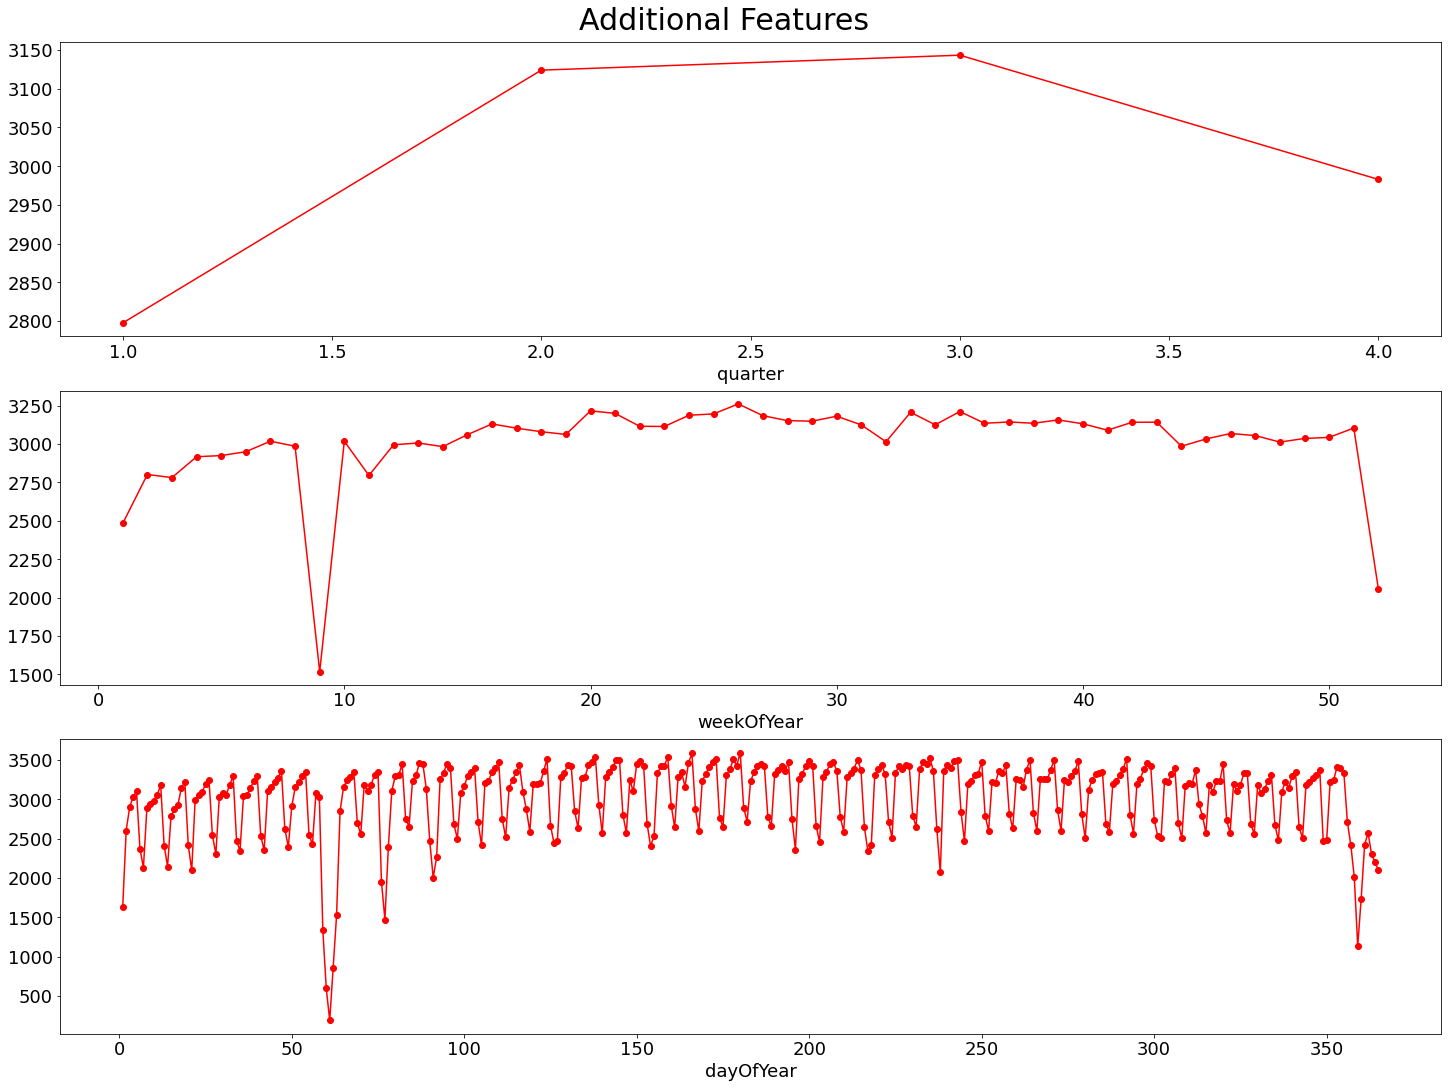

In [20]:
performance(df_north, "northBound")
visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_north, "Additional Features", "northBound")


performance(df_south, "southBound")
visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_south, "Additional Features", "southBound")

### Review:
Looks like our base features do best.
Newer features perform quite poorly, though this could be because we have such a small dataset right now.#
However, the dayOfYear plot demonstrates some pretty significant seasonality.

In [21]:
# Get our dataframes back to original features by running cell towards top
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

## Feature Engineering
### Create lagging features
#### Need to encode components of time series data such as seasonality, trend and cycles.

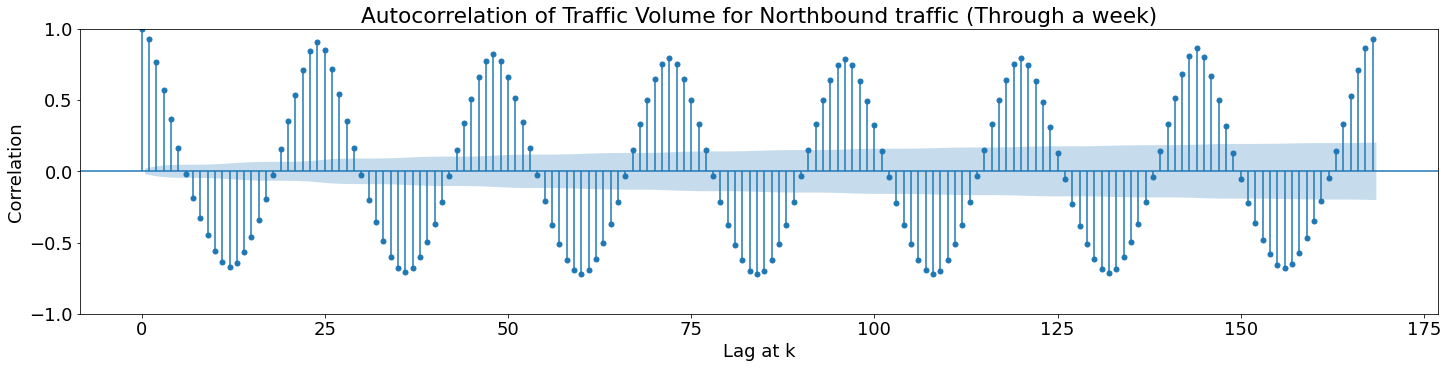

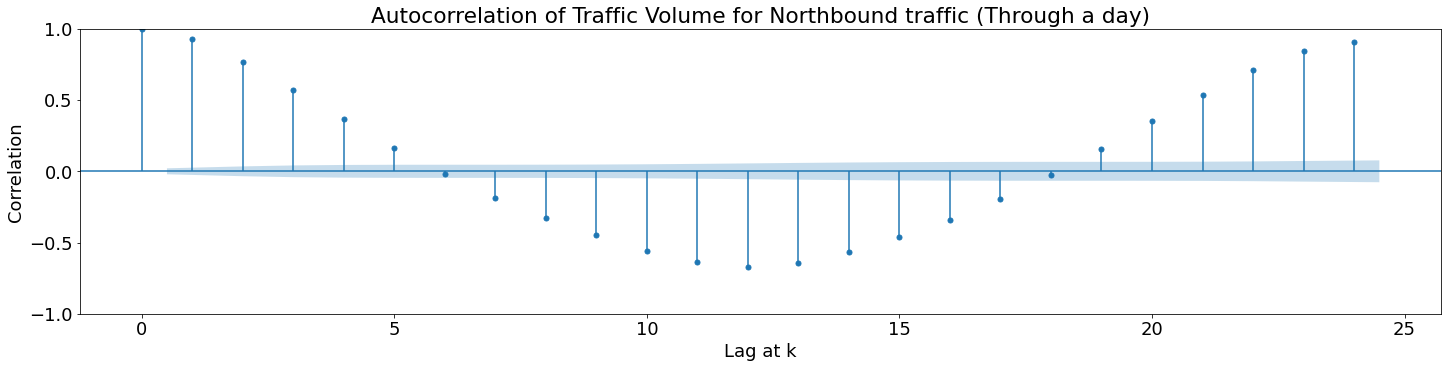

In [22]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=168)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a week)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

Base MSE for northBound traffic is: 313.77581191666246
Base MSE for northBound traffic is: 321.9761814357602
Base MSE for northBound traffic is: 323.6293916596153


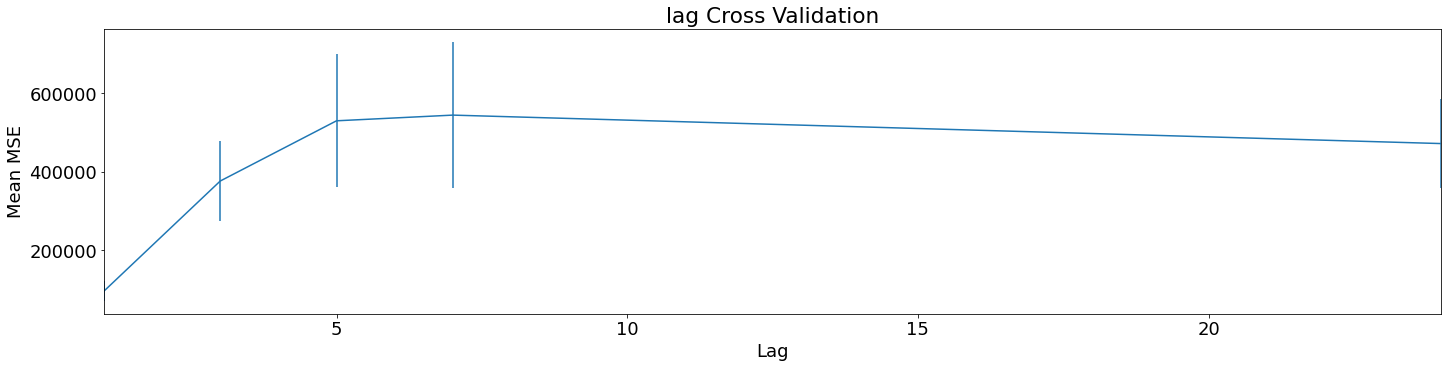

In [33]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[1,3,5,7,24], df=temp, feature_type="lag", target_var="northBound")

# Hour
temp["volume_lag_1"] = temp["northBound"].shift(1, fill_value=0)
performance(temp, "northBound")
# Day
temp["volume_lag_24"] = temp["northBound"].shift(24, fill_value=0)
performance(temp, "northBound")
# Week
temp["volume_lag_week"] = temp["northBound"].shift(168, fill_value=0)
performance(temp, "northBound")


Set a lag of 1

In [34]:
df_north = df.drop(columns=["southBound"])
df_north["volume_lag_1"] = df_north["northBound"].shift(1, fill_value=0)
performance(df_north, "northBound")

df_south = df.drop(columns=["northBound"])
df_south["volume_lag_1"] = df_south["southBound"].shift(1, fill_value=0)
performance(df_south, "southBound")

Base MSE for northBound traffic is: 309.6605527309318
Base MSE for southBound traffic is: 351.84208412792816


Some improvement when using a lag of 1. Anything higher results in pretty poor results, Let's try a Rolling Window Feature

### Rolling Window Features
For this, we'll try the mean, min, max, and sum in each window.

Base MSE for northBound traffic is: 212.1171343783997


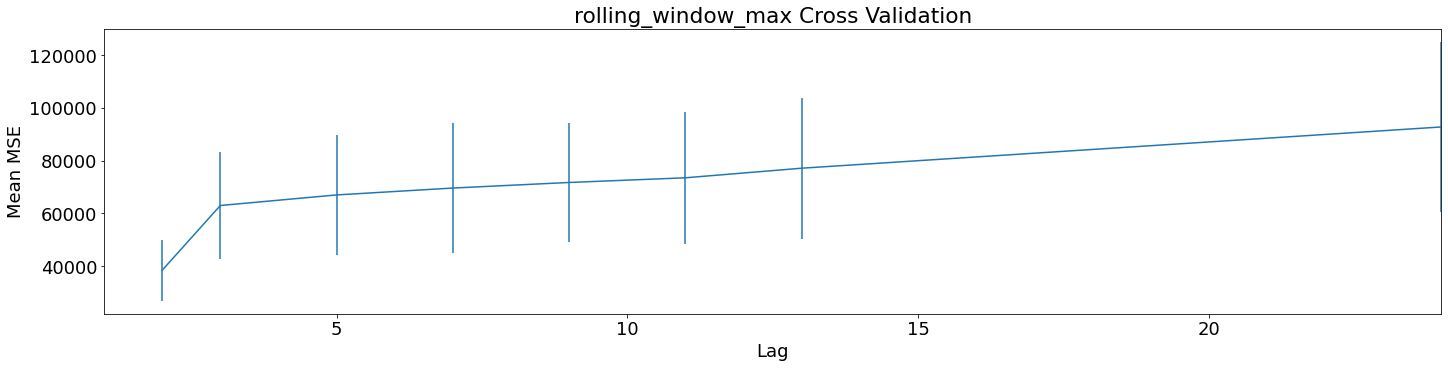

In [37]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13,24], df=temp, feature_type="rolling_window_max", target_var="northBound")
temp['window_max'] = temp['northBound'].rolling(window = 2).max()
temp['window_max'] = temp['window_max'].fillna(0)
performance(temp, "northBound")




Lower error again with the rolling window. Try mean rolling window

Base MSE for northBound traffic is: 121.36380972896642


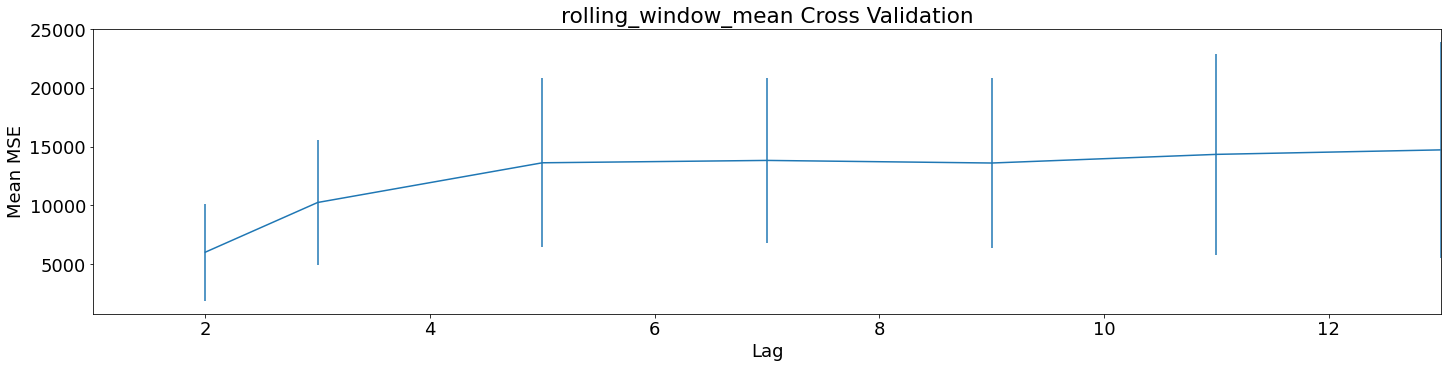

In [46]:
temp_a = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_mean", target_var="northBound")
temp['window_mean'] = temp['northBound'].rolling(window = 2).mean()
temp['window_mean'] = temp['window_mean'].fillna(0)
performance(temp, "northBound")

Much better again! See if min does any better

Base MSE for northBound traffic is: 199.94640625894115


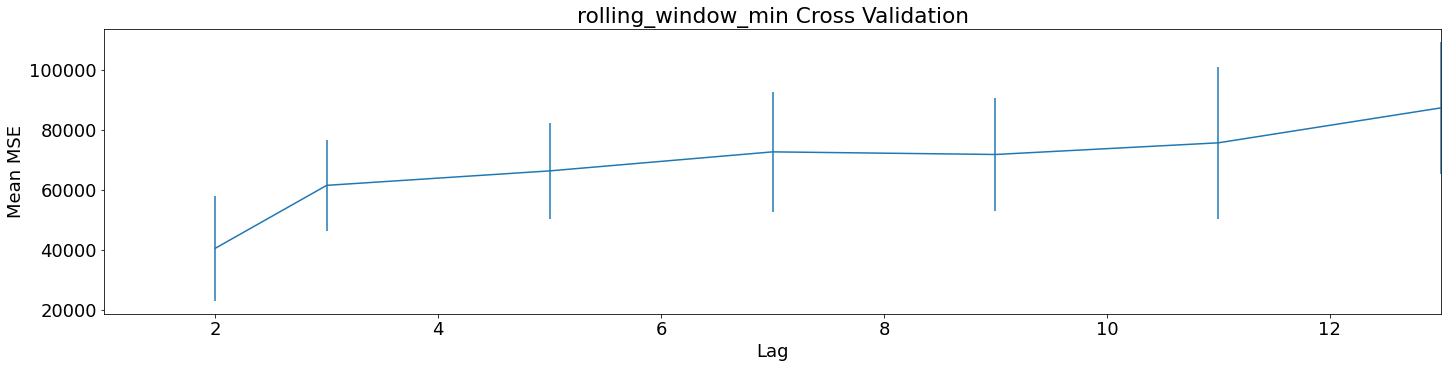

In [41]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_min", target_var="northBound")
temp['window_min'] = temp['northBound'].rolling(window = 2).min()
temp['window_min'] = temp['window_min'].fillna(0)
performance(temp, "northBound")

Not quite as good.

Let's add the mean rolling window as a feature

In [44]:
# Northbound
df_north['window_mean'] = df_north['northBound'].rolling(window = 2).mean()
df_north['window_mean'] = df_north['window_mean'].fillna(0)
performance(df_north, "northBound")
# Southbound
df_south['window_mean'] = df_south['southBound'].rolling(window = 2).mean()
df_south['window_mean'] = df_south['window_mean'].fillna(0)
performance(df_south, "southBound")

Base MSE for northBound traffic is: 89.07511151251049
Base MSE for southBound traffic is: 93.5704978453466


We see better performance as we dont have the cross validated features also in the dataframe. 
This performance is particularly good for such a basic model!

## Model Training

We're going to try a few different models provided by sklearn. We could look beyond into things like Keras, ARIMA and XGBOOST, but I don't think it's necessary for this assignment.


Hold out a validation set.

In [48]:
from sklearn.model_selection import train_test_split

# Target Variable
y_north = df_north["northBound"]
y_south = df_south["southBound"]

# Feature Vectors
X_north = df_north.drop(columns=["northBound"]).to_numpy()
X_south = df_south.drop(columns=["southBound"]).to_numpy()

# Hold out a validation set
X_north, X_north_val, y_north, y_north_val = train_test_split(X_north, y_north, test_size=0.1, shuffle=False)
X_south, X_south_val, y_south, y_south_val = train_test_split(X_south, y_south, test_size=0.1, shuffle=False)

KeyError: "['northBound'] not found in axis"

So, let's look into Lasso and Ridge Regression first.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
